In [16]:
# This notebook processes the Vcontact2 data into a network.
# Many of steps in this notebook take some time (couple minutes / cell).
# Added progressbars where it seems appropriate.
# Could probably speed this up tremendously by using dask, but at this point I'm too lazy and the computation time is perfect for a coffee break.


#Since the size of names / nodes.dmp is to large, user should download manually.
### Input files needed:
# - c1.ntw: Network file obtained as output from Vcontact2.
# - namesRED.dmp: names.dmp file obtained from NCBI's taxonomy taxdump. Only column 1 and 3 are included (the '|' count as columns here)
# - ! the header of the namesRED is to be added manually, column 1 = tax, column2 = name
# - nodesRED.dmp: nodes.dmp file obtained from NCBI's taxonomy taxdump. Only column 1,3 and 5 included (the '|' count as columns here).
# - ! the header of the nodesRED is to be added manually, column1 = tax, column2 = parent, column3 = rank
# - proteinlist.csv: a list linking proteins to their genome/contig, and containing a keyword. Used for Vcontact2 analysis.

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from progressbar import *
from graph_tool.all import *
import seaborn as sns
from matplotlib.colors import BoundaryNorm
sns.set(font='arial')
sns.set_style("white")
sns.set_style("ticks")
%matplotlib inline
%matplotlib inline

In [18]:
#Build network (takes a while.)
g = Graph(directed=False)
allvert = {}
v_prop = g.new_vertex_property("string")
e_prop = g.new_edge_property("float")
with open('data/c1.ntw') as f:
    counter = 0
    for line in f:
        if line.strip().split(' ')[0] not in allvert:
            allvert[line.strip().split(' ')[0]] = counter
            counter += 1
            e = g.add_vertex()
            if 'NODE' in line.strip().split(' ')[0]:
                v_prop[e] = 'red'
            else:
                v_prop[e] = 'grey'
        if line.strip().split(' ')[1] not in allvert:
            allvert[line.strip().split(' ')[1]] = counter
            counter += 1
            e = g.add_vertex()
            if 'NODE' in line.strip().split(' ')[1]:
                v_prop[e] = 'red'
            else:
                v_prop[e] = 'grey'
        e = g.add_edge(allvert[line.strip().split(' ')[0]], allvert[line.strip().split(' ')[1]])
        e_prop[e] = float(line.strip().split(' ')[2])

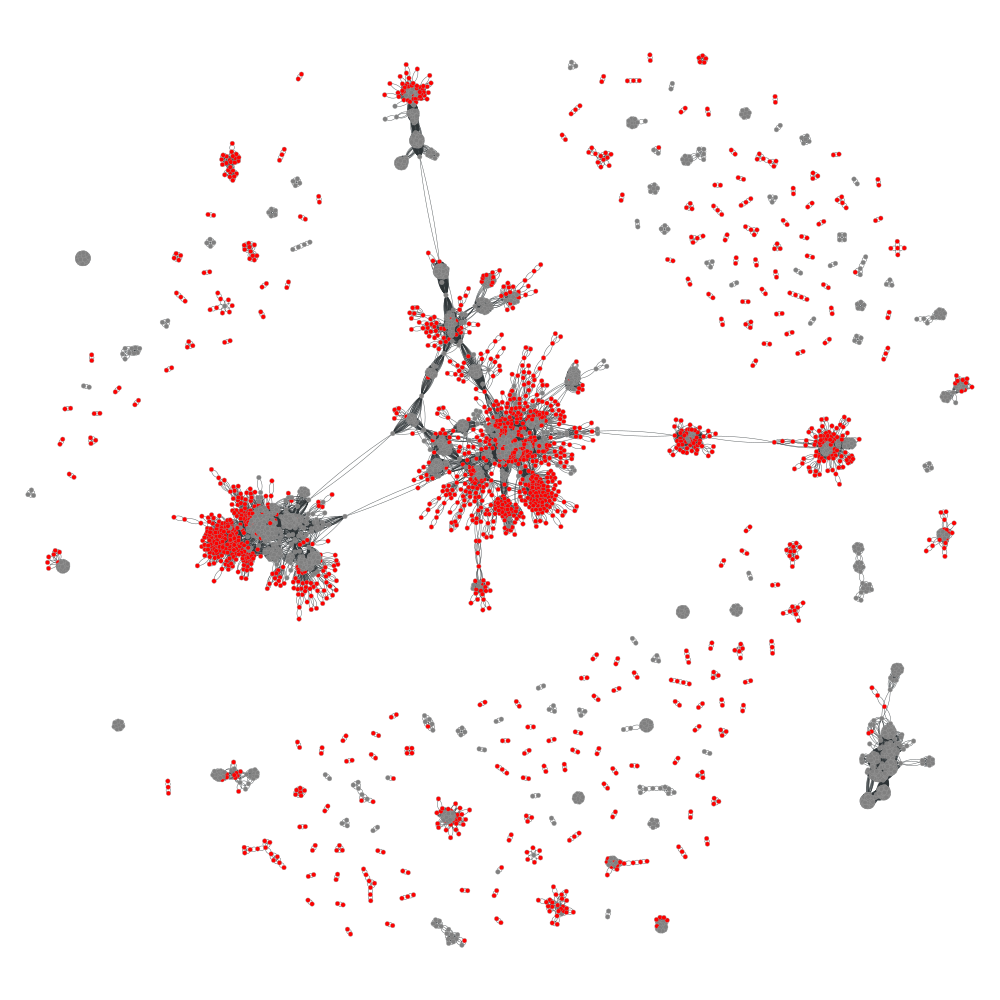

In [19]:
#Plot network
gfig = graph_draw(g, vertex_fill_color=v_prop,output_size=(1000, 1000))

In [20]:
#Get taxonomy information for reference sequences
#Carefull, this takes a long time.
reflist = []
with open('data/proteinlist.csv') as f:
    for line in f:
        if 'NODE' not in line.strip().split(',')[1] and 'contig_id' not in line.strip().split(',')[1] and  line.strip().split(',')[1] not in reflist:
            reflist.append(line.strip().split(',')[1])

widgets = ['Running through names.dmp. ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),' ', ETA(), ' ', FileTransferSpeed()]
pbar = ProgressBar(widgets=widgets, maxval=len(reflist))
pbar.start()

names=pd.read_csv("data/namesRED.dmp",delimiter='\t',encoding='utf-8')
taxdic = {}
counter = 0
for i in reflist:
    counter += 1
    get = names.loc[names['name'] == i]
    if len(get) == 1:
        taxdic[i] = get.iloc[0]['tax']
    else:
        taxdic[i] = "unclass"
    pbar.update(counter)
pbar.finish()

widgets = ['Running through nodes.dmp. ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),' ', ETA(), ' ', FileTransferSpeed()]
pbar = ProgressBar(widgets=widgets, maxval=len(taxdic))
pbar.start()

nodes=pd.read_csv("data/nodesRED.dmp",delimiter='\t',encoding='utf-8')
taxpathlist = []
counter = 0
for i in taxdic:
    counter += 1
    if taxdic[i] != "unclass":
        name = i
        curtax = taxdic[i]
        templist = [name,curtax]
        while curtax != 1:
            newnod = nodes.loc[nodes['tax'] == curtax]
            curtax = newnod.iat[0,1]
            templist.append(curtax)
        taxpathlist.append(templist)
    else:
        name = i
        curtax = taxdic[i]
        templist = [name,curtax]
        taxpathlist.append(templist)
    pbar.update(counter)
pbar.finish()

Running through names.dmp. 100% [0000000000000000000] Time: 0:06:21   5.92  B/s
Running through nodes.dmp. 100% [0000000000000000000] Time: 0:00:35  62.82  B/s


In [21]:
#With names & nodes.dmp parsed, put together the information.
widgets = ['Combining tax info. ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),' ', ETA(), ' ', FileTransferSpeed()]
pbar = ProgressBar(widgets=widgets, maxval=len(taxpathlist))
pbar.start()

namedlist = []
nodelist = []
nameddic = []
counter = 0
for i in taxpathlist:
    counter += 1
    namerank = {}
    node = i[0]
    for k in range(len(i)):
        if k != 0:
            name = names.loc[names['tax'] == int(i[k])]
            rank = nodes.loc[nodes['tax'] == int(i[k])]
            newname = name.iat[0,1]
            newrank = rank.iat[0,2]
            namerank[newrank] = newname
    nestlist = [node, namerank]
    namedlist.append(nestlist)
    nodelist.append(node)
    nameddic.append(namerank)
    pbar.update(counter)
pbar.finish()
virdf = pd.DataFrame(nameddic, index=nodelist)
virdf.to_csv("output/refclas.csv")

Combining tax info. 100% [00000000000000000000000000] Time: 0:01:36  23.39  B/s


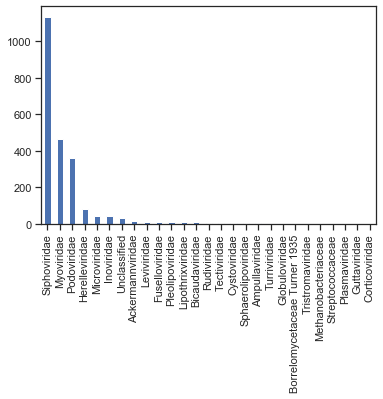

In [28]:
#Plots for family level
refdf = pd.read_csv('output/refclas.csv')
refdf = refdf.fillna('Unclassified')
refdf['family'].value_counts().plot(kind='bar')

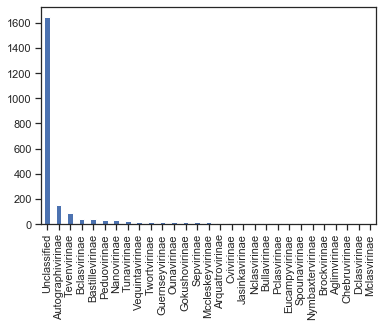

In [29]:
#Plots for subfamily level
refdf = pd.read_csv('output/refclas.csv')
refdf = refdf.fillna('Unclassified')
refdf['subfamily'].value_counts().plot(kind='bar')

In [41]:
refdf = pd.read_csv('output/refclas.csv')
refdf = refdf.fillna('Unclassified')

['Unnamed: 0',
 'species',
 'no rank',
 'genus',
 'subfamily',
 'family',
 'order',
 'superkingdom',
 'class',
 'phylum']

In [35]:
#unclass = grey
#NODE = coral
## myo = khaki
## podo = forestgreen
## sipho = brown
#23 ranges:
#yellow
pal = sns.color_palette("Blues", 23).as_hex()
pal

['#eff6fc',
 '#e7f0fa',
 '#deebf7',
 '#d6e6f4',
 '#cee0f2',
 '#c6dbef',
 '#b9d6ea',
 '#abd0e6',
 '#9dcae1',
 '#8dc1dd',
 '#7cb7da',
 '#6aaed6',
 '#5da5d1',
 '#4f9bcb',
 '#4191c6',
 '#3787c0',
 '#2c7cba',
 '#2070b4',
 '#1966ad',
 '#105ba4',
 '#08509b',
 '#08468b',
 '#083a7a']

In [42]:
#Plot with the colors for families:
refdf = pd.read_csv('output/refclas.csv')
refdf = refdf.fillna('Unclassified')
refdf.columns = ['name',
 'species',
 'no rank',
 'genus',
 'subfamily',
 'family',
 'order',
 'superkingdom',
 'class',
 'phylum']

coldic = {'Myoviridae':'khaki',
          'Podoviridae':'forestgreen',
          'Siphoviridae':'#ff7f0e',
          'Unclassified':'black',
          'Borrelomycetaceae Turner 1935':'#d6e6f4',
          'Methanobacteriaceae':'#4f9bcb',
          'Cystoviridae':'#c6dbef',
          'Tectiviridae':'#08509b',
          'Pleolipoviridae':'#2c7cba',
          'Microviridae':'#4191c6',
          'Ackermannviridae':'#eff6fc',
          'Tristromaviridae':'#08468b',
          'Rudiviridae':'#2070b4',
          'Fuselloviridae':'#b9d6ea',
          'Lipothrixviridae':'#5da5d1',
          'Turriviridae':'#083a7a',
          'Inoviridae':'#7cb7da',
          'Bicaudaviridae':'#deebf7',
          'Sphaerolipoviridae':'#1966ad',
          'Ampullaviridae':'#e7f0fa',
          'Leviviridae':'#6aaed6',
          'Guttaviridae':'#9dcae1',
          'Plasmaviridae':'#3787c0',
          'Streptococcaceae':'#105ba4',
          'Globuloviridae':'#abd0e6',
          'Corticoviridae':'#cee0f2',
          'Herelleviridae':'#8dc1dd'}
#Read the df again, and fix columns.
#Build a new network.
colg = Graph(directed=False)
allvert = {}
v_prop = colg.new_vertex_property("string")
e_prop = colg.new_edge_property("float")
with open('data/c1.ntw') as f:
    counter = 0
    for line in f:
        if line.strip().split(' ')[0] not in allvert:
            allvert[line.strip().split(' ')[0]] = counter
            counter += 1
            e = colg.add_vertex()
            if 'NODE' in line.strip().split(' ')[0]:
                v_prop[e] = 'red'
            else:
                newnod = refdf.loc[refdf['name'] == line.strip().split(' ')[0].replace('~',' ')]
                v_prop[e] = coldic[newnod.iloc[0]['family']]
        if line.strip().split(' ')[1] not in allvert:
            allvert[line.strip().split(' ')[1]] = counter
            counter += 1
            e = colg.add_vertex()
            if 'NODE' in line.strip().split(' ')[1]:
                v_prop[e] = 'red'
            else:
                newnod = refdf.loc[refdf['name'] == line.strip().split(' ')[1].replace('~',' ')]
                v_prop[e] = coldic[newnod.iloc[0]['family']]
        e = colg.add_edge(allvert[line.strip().split(' ')[0]], allvert[line.strip().split(' ')[1]])
        e_prop[e] = float(line.strip().split(' ')[2])

In [43]:
#Plot network
#graph_draw(colg, vertex_fill_color=v_prop,output_size=(1000, 1000))
graph_draw(colg, vertex_fill_color=v_prop, output='figures/Bacteriophages_all.png',output_size=(5000, 5000))

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x1a4743ceb8, at 0x1a46a42cc0>

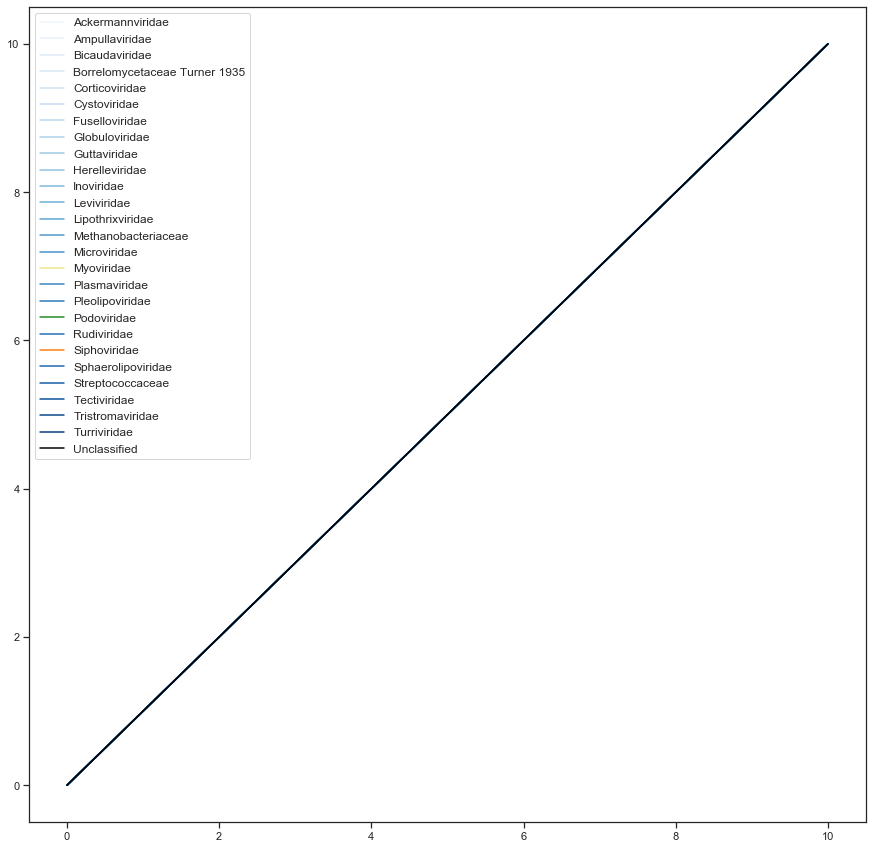

In [44]:
#Just plot some random data to grab the legend later and combine both figures.
import pylab
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
coldic = {'Myoviridae':'khaki',
          'Podoviridae':'forestgreen',
          'Siphoviridae':'#ff7f0e',
          'Unclassified':'black',
          'Borrelomycetaceae Turner 1935':'#d6e6f4',
          'Methanobacteriaceae':'#4f9bcb',
          'Cystoviridae':'#c6dbef',
          'Tectiviridae':'#08509b',
          'Pleolipoviridae':'#2c7cba',
          'Microviridae':'#4191c6',
          'Ackermannviridae':'#eff6fc',
          'Tristromaviridae':'#08468b',
          'Rudiviridae':'#2070b4',
          'Fuselloviridae':'#b9d6ea',
          'Lipothrixviridae':'#5da5d1',
          'Turriviridae':'#083a7a',
          'Inoviridae':'#7cb7da',
          'Bicaudaviridae':'#deebf7',
          'Sphaerolipoviridae':'#1966ad',
          'Ampullaviridae':'#e7f0fa',
          'Leviviridae':'#6aaed6',
          'Guttaviridae':'#9dcae1',
          'Plasmaviridae':'#3787c0',
          'Streptococcaceae':'#105ba4',
          'Globuloviridae':'#abd0e6',
          'Corticoviridae':'#cee0f2',
          'Herelleviridae':'#8dc1dd'}

fig, ax = plt.subplots(figsize=(15,15))
x = np.linspace(0, 10, 1000)
for i in sorted(coldic):
    ax.plot(x,x , '-b', label=i, color=coldic[i])
leg = ax.legend(prop={'size': 12})
leg.figure.savefig('figures/legend.png', dpi=300)
plt.rcParams['svg.fonttype'] = 'none'
leg.figure.savefig('figures/legend.svg', dpi=300)

In [45]:
######################################Additional analysis with contigs > 5 kb #######################################################################
#Build network (takes a while.)
g = Graph(directed=False)
allvert = {}
v_prop = g.new_vertex_property("string")
e_prop = g.new_edge_property("float")
with open('data/c1_5000length.ntw') as f:
    counter = 0
    for line in f:
        if line.strip().split(' ')[0] not in allvert:
            allvert[line.strip().split(' ')[0]] = counter
            counter += 1
            e = g.add_vertex()
            if 'NODE' in line.strip().split(' ')[0]:
                v_prop[e] = 'red'
            else:
                v_prop[e] = 'grey'
        if line.strip().split(' ')[1] not in allvert:
            allvert[line.strip().split(' ')[1]] = counter
            counter += 1
            e = g.add_vertex()
            if 'NODE' in line.strip().split(' ')[1]:
                v_prop[e] = 'red'
            else:
                v_prop[e] = 'grey'
        e = g.add_edge(allvert[line.strip().split(' ')[0]], allvert[line.strip().split(' ')[1]])
        e_prop[e] = float(line.strip().split(' ')[2])

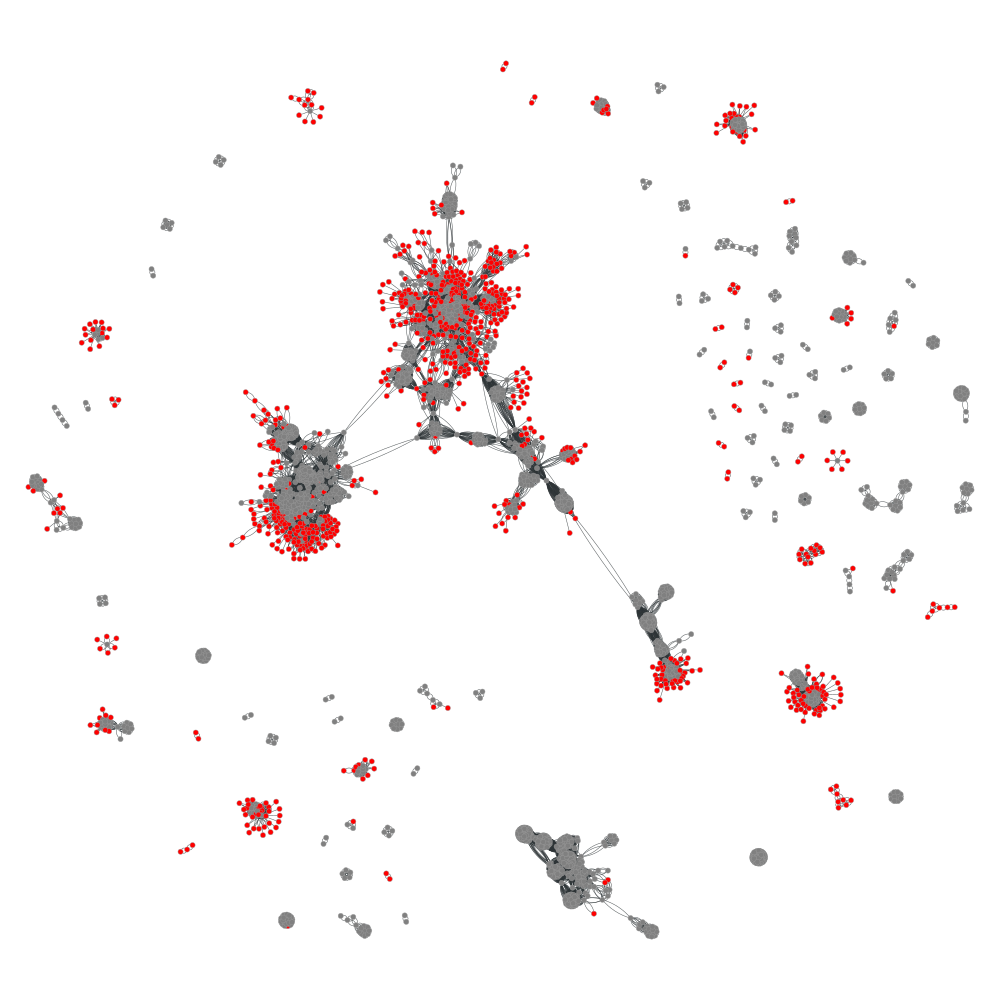

In [46]:
#Plot network
gfig = graph_draw(g, vertex_fill_color=v_prop,output_size=(1000, 1000))

In [47]:
#With names & nodes.dmp parsed, put together the information.
widgets = ['Combining tax info. ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),' ', ETA(), ' ', FileTransferSpeed()]
pbar = ProgressBar(widgets=widgets, maxval=len(taxpathlist))
pbar.start()

namedlist = []
nodelist = []
nameddic = []
counter = 0
for i in taxpathlist:
    counter += 1
    namerank = {}
    node = i[0]
    for k in range(len(i)):
        if k != 0:
            name = names.loc[names['tax'] == int(i[k])]
            rank = nodes.loc[nodes['tax'] == int(i[k])]
            newname = name.iat[0,1]
            newrank = rank.iat[0,2]
            namerank[newrank] = newname
    nestlist = [node, namerank]
    namedlist.append(nestlist)
    nodelist.append(node)
    nameddic.append(namerank)
    pbar.update(counter)
pbar.finish()
virdf = pd.DataFrame(nameddic, index=nodelist)
virdf.to_csv("output/refclas_5000.csv")

Combining tax info. 100% [00000000000000000000000000] Time: 0:01:34  23.83  B/s


In [50]:
refdf = pd.read_csv('output/refclas_5000.csv')
refdf = refdf.fillna('Unclassified')
list(refdf.columns)

['Unnamed: 0',
 'species',
 'no rank',
 'genus',
 'subfamily',
 'family',
 'order',
 'superkingdom',
 'class',
 'phylum']

In [51]:
pal = sns.color_palette("Blues", 23).as_hex()
pal
#Plot with the colors for families:
refdf = pd.read_csv('output/refclas_5000.csv')
refdf = refdf.fillna('Unclassified')
refdf.columns = ['name',
 'species',
 'no rank',
 'genus',
 'subfamily',
 'family',
 'order',
 'superkingdom',
 'class',
 'phylum']
coldic = {'Myoviridae':'khaki',
          'Podoviridae':'forestgreen',
          'Siphoviridae':'#ff7f0e',
          'Unclassified':'black',
          'Borrelomycetaceae Turner 1935':'#d6e6f4',
          'Methanobacteriaceae':'#4f9bcb',
          'Cystoviridae':'#c6dbef',
          'Tectiviridae':'#08509b',
          'Pleolipoviridae':'#2c7cba',
          'Microviridae':'#4191c6',
          'Ackermannviridae':'#eff6fc',
          'Tristromaviridae':'#08468b',
          'Rudiviridae':'#2070b4',
          'Fuselloviridae':'#b9d6ea',
          'Lipothrixviridae':'#5da5d1',
          'Turriviridae':'#083a7a',
          'Inoviridae':'#7cb7da',
          'Bicaudaviridae':'#deebf7',
          'Sphaerolipoviridae':'#1966ad',
          'Ampullaviridae':'#e7f0fa',
          'Leviviridae':'#6aaed6',
          'Guttaviridae':'#9dcae1',
          'Plasmaviridae':'#3787c0',
          'Streptococcaceae':'#105ba4',
          'Globuloviridae':'#abd0e6',
          'Corticoviridae':'#cee0f2',
          'Herelleviridae':'#8dc1dd'}
#Build a new network.
colg = Graph(directed=False)
allvert = {}
v_prop = colg.new_vertex_property("string")
e_prop = colg.new_edge_property("float")
with open('data/c1_5000length.ntw') as f:
    counter = 0
    for line in f:
        if line.strip().split(' ')[0] not in allvert:
            allvert[line.strip().split(' ')[0]] = counter
            counter += 1
            e = colg.add_vertex()
            if 'NODE' in line.strip().split(' ')[0]:
                v_prop[e] = 'red'
            else:
                newnod = refdf.loc[refdf['name'] == line.strip().split(' ')[0].replace('~',' ')]
                v_prop[e] = coldic[newnod.iloc[0]['family']]
        if line.strip().split(' ')[1] not in allvert:
            allvert[line.strip().split(' ')[1]] = counter
            counter += 1
            e = colg.add_vertex()
            if 'NODE' in line.strip().split(' ')[1]:
                v_prop[e] = 'red'
            else:
                newnod = refdf.loc[refdf['name'] == line.strip().split(' ')[1].replace('~',' ')]
                v_prop[e] = coldic[newnod.iloc[0]['family']]
        e = colg.add_edge(allvert[line.strip().split(' ')[0]], allvert[line.strip().split(' ')[1]])
        e_prop[e] = float(line.strip().split(' ')[2])

In [52]:
#Plot network
#graph_draw(colg, vertex_fill_color=v_prop,output_size=(1000, 1000))
graph_draw(colg, vertex_fill_color=v_prop, output='figures/Bacteriophages_5000.png',output_size=(5000, 5000))

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x1a49e67208, at 0x1a48e14e80>